# Pipeline

imports

In [238]:
import json
import os
import csv
import time
import numpy as np
import datetime
import random
import shutil
# from scipy.stats import norm
from itertools import product 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import yaml
# from ruamel.yaml import YAML

In [239]:
import sys
print(sys.path)
src_path = os.path.join(os.getcwd(), 'src')
sys.path.append(src_path)
# print(src_path)

['/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python39.zip', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/lib-dynload', '', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/site-packages', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/site-packages/setuptools/_vendor', '/opt/gurobi201/linux32/lib/python2.5', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/Clou

In [240]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
# from src.utils import LogColumnNames
from src.log_stats_calculation import *
from src.simulators.param_manipulation import *
from src.sim_execution_and_evalaution import *
from src.logging import log_simulation, initialize_simulation_log, save_params, set_up_experiment_output_dir, save_simulation_log, create_results_dataframe
from src.search_strategies.grid_search import run_grid_search
from src.simulators.simod_discovery import discover_BPS_simod
from src.pipeline_utils import get_params_to_change, set_target_val_and_range
from src.evaluation import generate_and_plot_quadtree_metrics, plot_quadtree_metrics_over_depth, evaluate_quadtree_vs_simulation_log, evaluate_hyperquadtree_vs_simulation_log, compute_and_save_quadtree_metrics
from src.search_strategies.quadtree import adaptive_quadtree, plot_quadtree, write_nodes_visited_to_json, write_quadtree_nodes_to_file

In [242]:
from prosimos import simulation_engine, simulation_properties_parser
# from simod.simod import Simod
# from simod.event_log.event_log import EventLog
# from simod.settings.simod_settings import SimodSettings
from simod.simulation.prosimos import *


# Pipeline

## 0. Input

In [243]:
# - event_log: historical process data
# - target_PPI: performance metric (e.g., cycle time)
# - PPI_target_range: acceptable range (e.g., [0, 5])
# - simulation_tool: engine for discrete-event simulation
# - changeable_parameters_list: list of parameters to vary
# # - simulation_model: built from event_log


# Inputs
# process_name = 'dummy_2tasks'
# process_name = 'ten_activities'
# process_name = 'LoanApp'
# process_name = 'LoanApp_SingleRole'
process_name = 'LoanApp_SingleRole_fixDuration'
# process_name = 'LoanApp_TwoRoles'

# target_ppis = ['idle_cycle_time', 'cost']
# target_ppis = ['lead_time', 'cost']
target_ppis = ['lead_time']
# target_ppis = ['cost']
ppi_bounds = {
    'lead_time': 'upper',
    'cost': 'upper'
}

ppi_range_factor = 0.35

cases_to_simulate = 100
discover_bps_model = False
nr_simulations_per_scenario = 1
execute_strategy = ['grid_search', 'hyperquadtree'] #  'quadtree', 'diagonal_search', 'hill_climbing'

confidence = 0.95
beta = 0.9 
calculate_stats = 'custom'  # 'custom' or 'simod'
dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
simulation_tool = 'simod'

print_intermediate_results = True

# internal parameters
decimals = 2
# retain_simulation_data = False
simulation_results_confidence = True
in_out_criteria = "confidence"  # "mean" or "confidence"
simod_config_path = 'simulators/simod/resources/config/config_one-shot.yml'
simod_directory = 'simulators/simod'
ppi_calculation = {
    'cost': {
        'type': 'total',
        'method': 'full_duration', # full_duration, active_time, combined
        'weight': 1.5         # only applicable for 'combined' method
    },
    'lead_time': {
        'type': 'avg'}
    }
update_parameters_list = ['resource_count', 'branching_probability']




In [244]:

# parameters to change

''''
Possible values: 
    - continous ("cont"),
    - discrete ("disc"), 
    - categorical ("cat").

Define ranges for each parameter:
    - continuous: [min, max]    
    - discrete: [min, max]
    - categorical: [list of possible values]
'''

input_parameters = {
    'arriaval_distr_mean': {
        'type': 'cont',
        'values': [60*5, 60*60*3]  # 5 min to 3 hours
    },  
    'resource_count': {
        'type': 'disc',
        'values': [1, 21],  # 1 to 26 resources
        'ignore': ['applicant']
    },
    # 'branching_probability': {
    #     'type': 'cont',
    #     'values': [0, 1],  # 0% to 100%,
    #     'ignore': ['node_645ee027-7ae8-4f3a-9127-f99918deb220'], # Ignore all of these gateways
    #     'use':    ['node_ca4fbec9-1f9a-4f95-b2fe-a143fbe4277f']  # If given, only use these gateways
    # }
}



In [245]:
# Write inputs into 
base_path = os.path.join('data', process_name)

dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

params = {
    'process_name': process_name,
    'base_path': base_path,
    'target_ppis': target_ppis,
    'ppi_bounds': ppi_bounds,
    'ppi_range_factor': ppi_range_factor,
    'cases_to_simulate': cases_to_simulate,
    'starting_at':dt_str,
    'simulation_tool': simulation_tool,
    'nr_simulations_per_scenario': nr_simulations_per_scenario,
    'decimals': decimals,
    'simulation_results_confidence': simulation_results_confidence,
    'calculate_stats': calculate_stats,
    'confidence': confidence,
    'beta': beta,
    'in_out_criteria': in_out_criteria,
    'print_intermediate_results': print_intermediate_results,
    'execute_strategy': execute_strategy,
    'simod_config_path': simod_config_path,
    'simod_directory': simod_directory,
    'ppi_calculation': ppi_calculation,
    'input_parameters': input_parameters,
    'update_parameters_list': update_parameters_list
}


results = {}

In [246]:


params['strategies'] = {
    'grid_search': {
        'granularity': 25,
        'input': 'original_input' 
    },
    'hyperquadtree': {
        'min_depth': 1,
        'max_depth': 10
    },
    'quadtree': {
        'min_depth': 3,
        'max_depth': 6
    },
    'diagonal_search': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        'adaptive_step': True,
        'strictness': 0.01
    },
    'hill_climbing': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        # 'adaptive_step': True,
        'candidate_strategy': 'random_one',
        'walk_reps_max': 100
    }
}

In [247]:
# params[cases_to_simulate] = 100
# params['nr_simulations_per_scenario'] = 1
# params['confidence'] = confidence
# params['print_intermediate_results'] = False
# params['target_ppis'] = ['lead_time', 'cost']
# params['execute_strategy'] = ['grid_search', 'quadtree', 'hyperquadtree']
# ppi = 'cost'
# metric_type = params['ppi_calculation'][ppi]['type']
# calculation_method = params['ppi_calculation'][ppi]['type']
# metric_type, calculation_method

### 0.5 Discovery

#### implement automatic calling of discovery

In [248]:
# def copy_simod_files(params):
#     """
#     Copies the BPMN and JSON files from the 'best_result' directory to the base directory.

#     Args:
#         params (dict): Dictionary containing configuration parameters, including 'print_intermediate_results'.

#     Returns:
#         None
#     """

#     base_path = params['base_path']
#     process_name = params['process_name']

#     # Define source paths
#     bpmn_src = os.path.join(base_path, 'best_result', process_name + '.bpmn')
#     json_src = os.path.join(base_path, 'best_result', process_name + '.json')

#     # Define destination paths
#     bpmn_dest = os.path.join(base_path, process_name + '.bpmn')
#     json_dest = os.path.join(base_path, process_name + '.json')

#     # Helper function to conditionally print messages
#     def conditional_print(message):
#         if params.get('print_intermediate_results', False):
#             print(message)

#     # Copy the BPMN file
#     try:
#         shutil.copy(bpmn_src, bpmn_dest)
#         conditional_print(f"Copied BPMN file from {bpmn_src} to {bpmn_dest}")
#     except FileNotFoundError:
#         conditional_print(f"Error: BPMN file not found at {bpmn_src}")
#     except Exception as e:
#         conditional_print(f"Error copying BPMN file: {e}")

#     # Copy the JSON file
#     try:
#         shutil.copy(json_src, json_dest)
#         conditional_print(f"Copied JSON file from {json_src} to {json_dest}")
#     except FileNotFoundError:
#         conditional_print(f"Error: JSON file not found at {json_src}")
#     except Exception as e:
#         conditional_print(f"Error copying JSON file: {e}")

In [249]:
if discover_bps_model:

    discover_BPS_simod(params)

    # # Read and update the simod configuration file: set train_log_path
    # update_simod_config_train_path(params)

    # # Specify the path to the simod directory
    # simod_directory = os.path.join('simulators', 'simod')

    # # output = Path(os.path.join(simod_directory, 'resources', 'output'))
    # output = Path(os.path.join(params['base_path']))

    # configuration_path = Path(os.path.join(simod_directory, 'resources', 'config', 'config_one-shot.yml' ))
    # settings = SimodSettings.from_path(configuration_path)

    # # Read and preprocess event log
    # event_log = EventLog.from_path(
    #     log_ids=settings.common.log_ids,
    #     train_log_path=settings.common.train_log_path,
    #     # test_log_path=settings.common.test_log_path,
    #     preprocessing_settings=settings.preprocessing,
    #     need_test_partition=settings.common.perform_final_evaluation,
    # )

    # # Instantiate and run SIMOD
    # simod = Simod(settings=settings, event_log=event_log, output_dir=output)
    # simod.run()

    # # Copy the discovered model to the process data folder
    # copy_simod_files(params)

In [250]:
# reading in of temp BPS_model json file

# dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
# dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# if discover_bps_model:
#     bpmn_path = os.path.join(base_path, 'best_result', process_name + '.bpmn')
#     json_path = os.path.join(base_path, 'best_result', process_name + '.json')



# else:      
bpmn_path = os.path.join(params['base_path'], params['process_name'] + '.bpmn')
json_path = os.path.join(params['base_path'], params['process_name'] + '.json')


params['json_path'] = json_path
json_path_temp = create_temp_json(input_path=json_path, output_path=None)
params['bpmn_path'] = bpmn_path
params['json_path_temp'] = json_path_temp


##### BPMN plotting

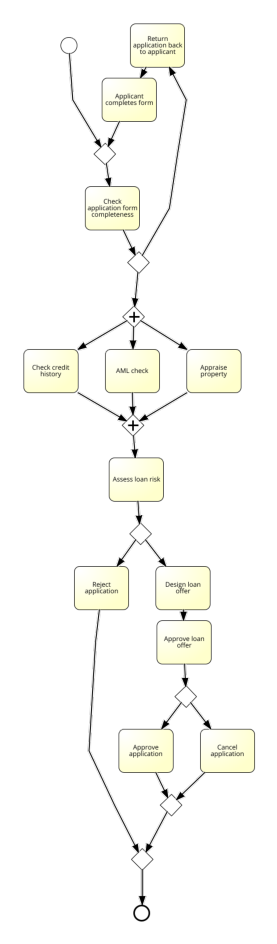

In [251]:

# Specify the path to your PNG file
name = params['process_name']
image_path = os.path.join(params['base_path'],  f'{name}.png')

try:
    # Load and display the image
    img = mpimg.imread(image_path)
    fig = plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.show()
except:
    print(f"Image file not found at {image_path}")

## 1.  Set up

### Required Input

### Adaptation based on input ranges and parameters to change

In [ ]:
# Add params_to_change to params dictionary
params['params_to_change'] = get_params_to_change(params)
# Initialize a global DataFrame to store simulation logs
simulation_log = initialize_simulation_log(params['params_to_change'])

# Create the DataFrame
results_df = create_results_dataframe()



Input parameters:
{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 10800]}, 'resource_count': {'type': 'disc', 'values': [1, 21], 'ignore': ['applicant']}}
Parameters to change:
{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 10800]}, 'resource_count_UnifiedResourceProfile': {'type': 'disc', 'values': [1, 21]}}



### Set up background

In [253]:
# Set up experiment output directory
params = set_up_experiment_output_dir(params)

Output directory ensured at: data/LoanApp_SingleRole_fixDuration/output/20251115_174434_2D_1PPIs_1n_0.95a_0.9b


In [268]:

params = set_target_val_and_range(params)

simulation_log = log_simulation(
    simulation_log=simulation_log,
    algorithm='orig_run',
    params=params,
    # target_ppi_dict=params['orig_target_ppi_val_dict'],
    target_ppi_dict=params['target_ppi_dict'],
    param_values=get_start_param_settings(params['params_to_change'], params),
)

print('''\n#############################\n###  Intermediate output  ###''')
for ppi in params['target_ppis']:
    val = params['orig_target_ppi_val_dict'][ppi]
    print(f'average {ppi}: {val}')
    val = params['target_range'][ppi]
    print(f'range: {val}\n')



#############################
###  Intermediate output  ###
average lead_time: 63682.0
range: [0, 85971.0]



In [264]:
# # Save paramas to json file in data/process_name/output/params.json
save_params(params)

# Write simulation log to CSV
save_simulation_log(simulation_log, params)

Parameters saved to data/LoanApp_SingleRole_fixDuration/output/20251115_174434_2D_1PPIs_1n_0.95a_0.9b/params.json
Simulation log saved to data/LoanApp_SingleRole_fixDuration/output/20251115_174434_2D_1PPIs_1n_0.95a_0.9b/simulation_log.csv


In [ ]:
simulation_log

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-11-15T15:30:19.012104Z,"{'lead_time': [0, 89136.0]}",True,[lead_time],{'lead_time': 66027.0},{'lead_time': [66027.0]},1800.0,19


## 2. Search

### Search strategies

#### Grid Search Pipeline

In [ ]:

%time

if 'grid_search' in params['execute_strategy']:

    # Start the timer
    start_time = time.perf_counter()

    simulation_log = run_grid_search(params, simulation_log=simulation_log)

    # Calculate elapsed time
    elapsed_time = time.perf_counter() - start_time

    save_simulation_log(simulation_log, params)

    result = {
        'experiment': params.get('experiment_name', None),
        'algorithm': 'grid_search',
        'evals': len(simulation_log[simulation_log['algorithm'] == 'grid_search']),
        'time': elapsed_time,
        'acc': '-',   
        'mcc': '-'    
    }
    # Append the new row to the DataFrame
    results_df = results_df.append(result, ignore_index=True)




CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs

Grid search ranges generated:
  arriaval_distr_mean: [300.0, 737.5, 1175.0, 1612.5, 2050.0, 2487.5, 2925.0, 3362.5, 3800.0, 4237.5, 4675.0, 5112.5, 5550.0, 5987.5, 6425.0, 6862.5, 7300.0, 7737.5, 8175.0, 8612.5, 9050.0, 9487.5, 9925.0, 10362.5, 10800.0]
  resource_count_UnifiedResourceProfile: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Total combinations to test: 525
Grid-search progress: 20% (105/525 combinations tested)
Grid-search progress: 40% (210/525 combinations tested)
Grid-search progress: 60% (315/525 combinations tested)
Grid-search progress: 80% (420/525 combinations tested)
Grid-search progress: 100% (525/525 combinations tested)
Simulation log saved to data/LoanApp_SingleRole_fixDuration/output/20251115_163018_2D_1PPIs_1n_0.95a_0.9b/simulation_log.csv


In [163]:
success_count = simulation_log[simulation_log["status"] == True].shape[0]
print(f"Number of simulation scenarios inside PPI range: {success_count}")
failed_count = simulation_log[simulation_log["status"] == False].shape[0]
print(f"Number of simulation scenarios outside PPI range: {failed_count}")

Number of simulation scenarios inside PPI range: 328
Number of simulation scenarios outside PPI range: 198


#### Hill Climbing

In [164]:
if 'hill_cimbing' in params['execute_strategy']:

    from src.search_strategies.hill_climbing import hill_descent

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    stepsize_initial = params['strategies']['hill_climbing']['stepsize_initial']
    step_max = params['strategies']['hill_climbing']['step_max']
    candidate_strategy = params['strategies']['hill_climbing']['candidate_strategy']
    walk_reps_max = params['strategies']['hill_climbing']['walk_reps_max'] 

    # Call the hill descent function
    hill_descent(
        params, 
        step_size_initial=stepsize_initial, 
        step_max=step_max, 
        params_to_change=params_to_change, 
        candidate_strategy=candidate_strategy, 
        walk_reps_max=walk_reps_max
        )

    # Save the simulation log to a CSV file for later analysis
    simulation_log.to_csv(params['simulation_log_path'], index=False)


#### Hpyerquadtree

##### Execute hyperquadtree



 # Evaluating corner at (300, 1)
  Target PPI Dict: {'lead_time': [9217768.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 21)
  Target PPI Dict: {'lead_time': [268486.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (10800, 1)
  Target PPI Dict: {'lead_time': [5925207.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (10800, 21)
  Target PPI Dict: {'lead_time': [39442.0]}
  In Target Range: True, Direction: in_range
Node at depth 1 - In Range: True, Out Range: True, Direction Range Same: False
Node at depth 1 classified as mixed
Iteration 0: Leaf Space = 0, Fraction = 0.0
  ## Space Fraction: 0.0, Beta: 0.9


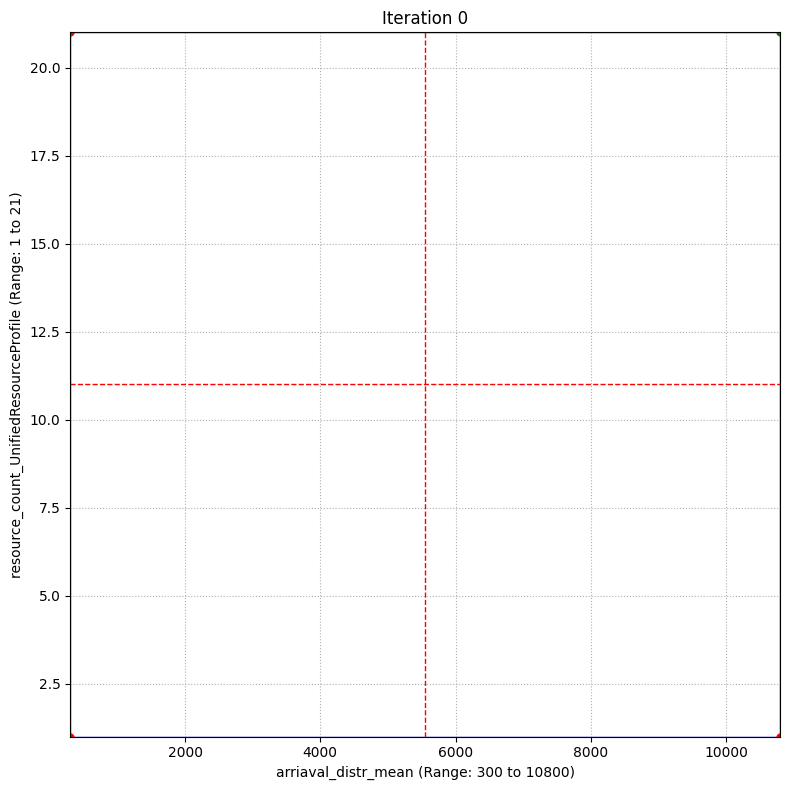



 # Evaluating corner at (300, 1)
  Target PPI Dict: {'lead_time': [9217768.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 11)
  Target PPI Dict: {'lead_time': [694094.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (5550.0, 1)
  Target PPI Dict: {'lead_time': [7751864.5]}
  In Target Range: False, Direction: above


 # Evaluating corner at (5550.0, 11)
  Target PPI Dict: {'lead_time': [62866.0]}
  In Target Range: True, Direction: in_range
Node at depth 2 - In Range: True, Out Range: True, Direction Range Same: False
Node at depth 2 classified as mixed


 # Evaluating corner at (300, 11)
  Target PPI Dict: {'lead_time': [694094.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 21)
  Target PPI Dict: {'lead_time': [268486.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (5550.0, 11)
  Target PPI Dict: {'lead_time': [62866.0]}
  In Target Range: True, Direction: in_range


 # E

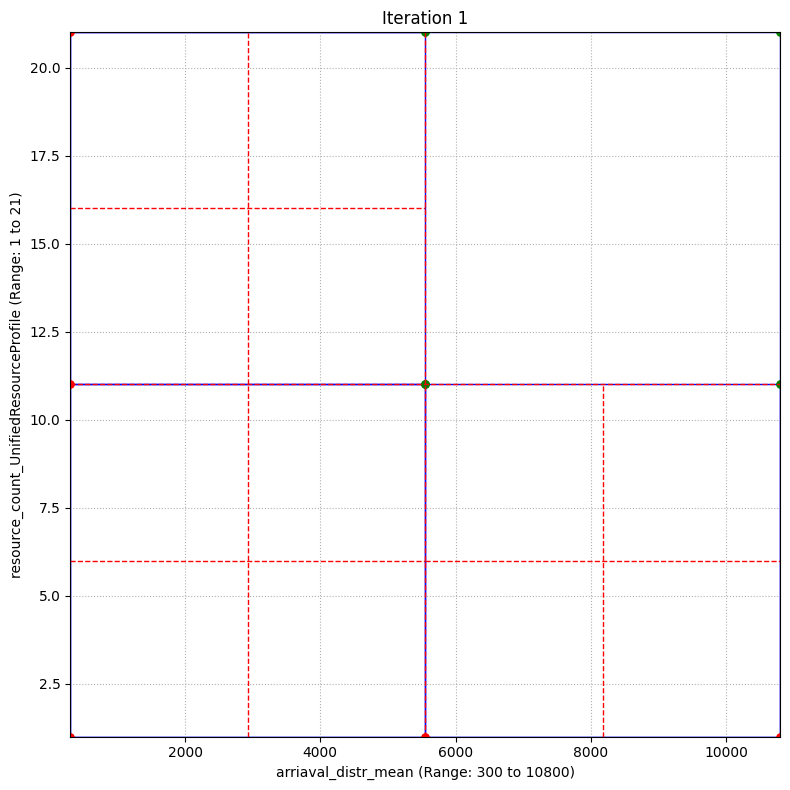



 # Evaluating corner at (300, 1)
  Target PPI Dict: {'lead_time': [9217768.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 6)
  Target PPI Dict: {'lead_time': [1330496.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2925.0, 1)
  Target PPI Dict: {'lead_time': [8459246.25]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2925.0, 6)
  Target PPI Dict: {'lead_time': [643432.0]}
  In Target Range: False, Direction: above
Node at depth 3 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 3 classified as out_range


 # Evaluating corner at (300, 6)
  Target PPI Dict: {'lead_time': [1330496.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 11)
  Target PPI Dict: {'lead_time': [694094.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2925.0, 6)
  Target PPI Dict: {'lead_time': [643432.0]}
  In Target Range: False, Direction: above


 # 

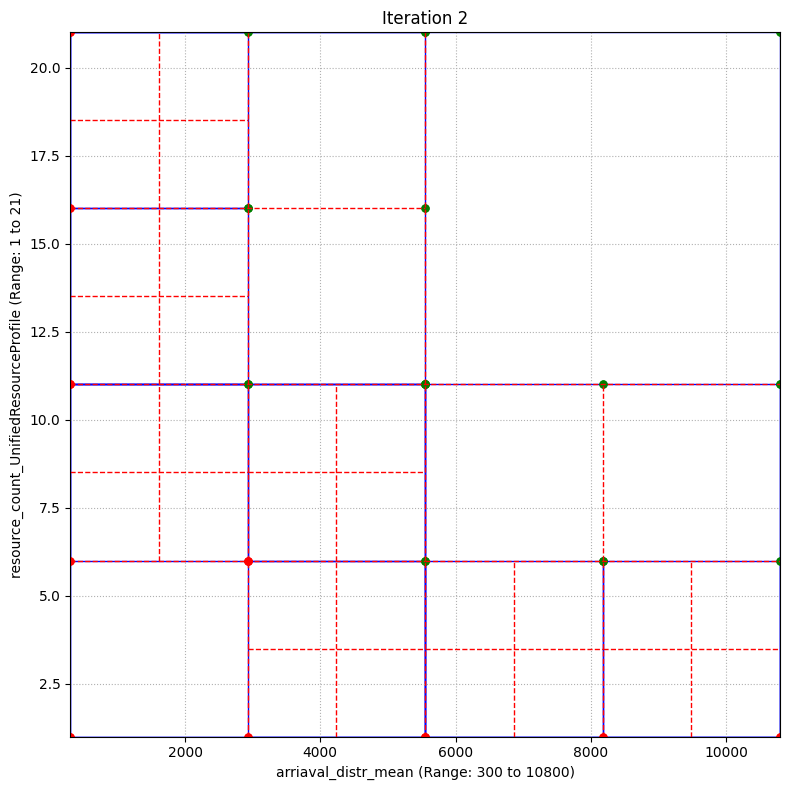



 # Evaluating corner at (300, 6)
  Target PPI Dict: {'lead_time': [1330496.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 8)
  Target PPI Dict: {'lead_time': [1051429.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (1612.5, 6)
  Target PPI Dict: {'lead_time': [1044625.625]}
  In Target Range: False, Direction: above


 # Evaluating corner at (1612.5, 8)
  Target PPI Dict: {'lead_time': [677022.625]}
  In Target Range: False, Direction: above
Node at depth 4 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 4 classified as out_range


 # Evaluating corner at (300, 8)
  Target PPI Dict: {'lead_time': [1051429.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 11)
  Target PPI Dict: {'lead_time': [694094.0]}
  In Target Range: False, Direction: above


 # Evaluating corner at (1612.5, 8)
  Target PPI Dict: {'lead_time': [677022.625]}
  In Target Range: False, Direction: above


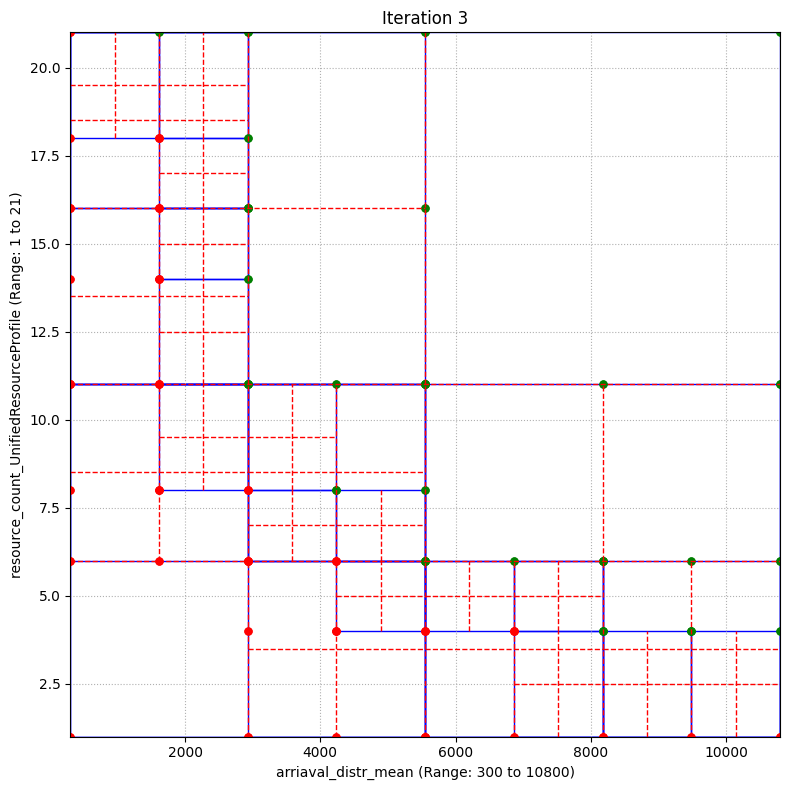



 # Evaluating corner at (1612.5, 8)
  Target PPI Dict: {'lead_time': [677022.625]}
  In Target Range: False, Direction: above


 # Evaluating corner at (1612.5, 10)
  Target PPI Dict: {'lead_time': [441182.75]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2268.75, 8)
  Target PPI Dict: {'lead_time': [506970.875]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2268.75, 10)
  Target PPI Dict: {'lead_time': [243228.9375]}
  In Target Range: False, Direction: above
Node at depth 5 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 5 classified as out_range


 # Evaluating corner at (1612.5, 10)
  Target PPI Dict: {'lead_time': [441182.75]}
  In Target Range: False, Direction: above


 # Evaluating corner at (1612.5, 11)
  Target PPI Dict: {'lead_time': [377344.875]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2268.75, 10)
  Target PPI Dict: {'lead_time': [243228.9375]}
  In Target Range: F

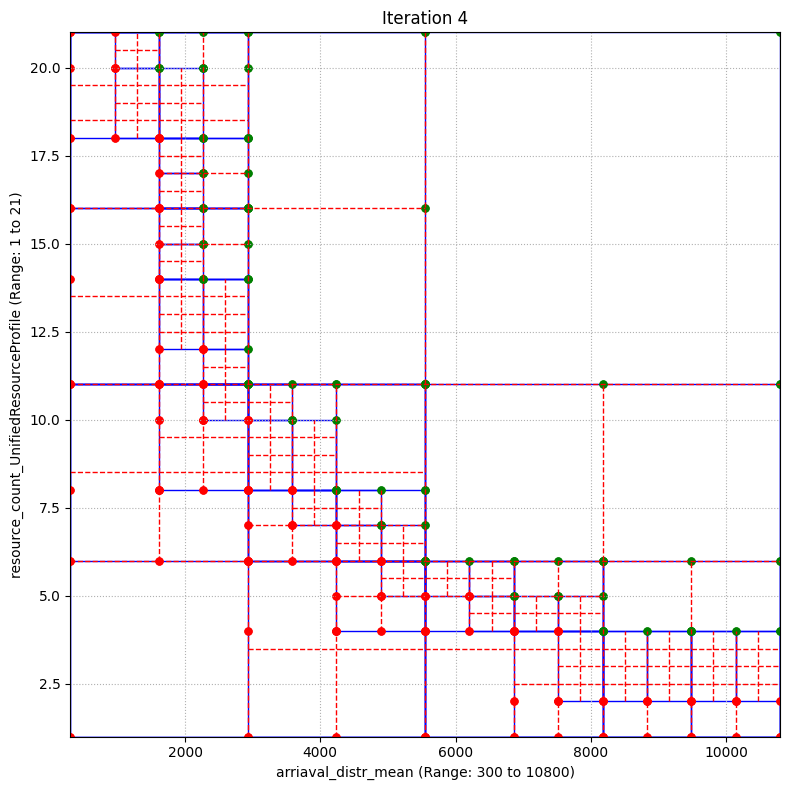



 # Evaluating corner at (2268.75, 10)
  Target PPI Dict: {'lead_time': [243228.9375]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2268.75, 10)
  Target PPI Dict: {'lead_time': [243228.9375]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2596.875, 10)
  Target PPI Dict: {'lead_time': [158912.21875]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2596.875, 10)
  Target PPI Dict: {'lead_time': [158912.21875]}
  In Target Range: False, Direction: above
Node at depth 6 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 6 classified as out_range


 # Evaluating corner at (2268.75, 10)
  Target PPI Dict: {'lead_time': [243228.9375]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2268.75, 11)
  Target PPI Dict: {'lead_time': [176229.5625]}
  In Target Range: False, Direction: above


 # Evaluating corner at (2596.875, 10)
  Target PPI Dict: {'lead_time': [158912.21875]}
 

AttributeError: 'DataFrame' object has no attribute 'append'

In [205]:
from src.search_strategies.hyperquadtree import adaptive_hyperquadtree, write_hyperquadtree_nodes_to_file, write_nodes_visited_to_json

if 'hyperquadtree' in params['execute_strategy']:


    min_depth = params['strategies']['hyperquadtree']['min_depth']
    max_depth = params['strategies']['hyperquadtree']['max_depth']

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    # Start the timer
    start_time = time.perf_counter()

    # Call the hyperquadtree function
    all_nodes, sampled_points, nodes_visited, simulation_log = adaptive_hyperquadtree(
        set_sim_params_get_sim_stats,
        is_in_target_range,
        params,
        simulation_log,
        min_depth=min_depth,
        max_depth=max_depth
    )

    # Calculate elapsed time
    elapsed_time = time.perf_counter() - start_time


    # log results
    save_simulation_log(simulation_log, params)

    params['strategies']['hyperquadtree']['paths'] = {}
    params['strategies']['hyperquadtree']['paths']['sampled_points'] = os.path.join(params['experiment_output_dir'], 'hyperquadtree_sampled_points.csv')
    params['strategies']['hyperquadtree']['paths']['nodes_visited'] = os.path.join(params['experiment_output_dir'], 'hyperquadtree_nodes_visited.csv')
    if params['print_intermediate_results']:
        print(params['strategies']['hyperquadtree']['paths'])
    
    save_params(params)
    write_hyperquadtree_nodes_to_file(all_nodes, params)
    write_nodes_visited_to_json(nodes_visited, params)

    max_depth_reached = len(nodes_visited)

    results_hqt = compute_and_save_quadtree_metrics(all_nodes, 
                                    simulation_log, 
                                    params, 
                                    nodes_visited, 
                                    max_depth=max_depth_reached, 
                                    algorithm='hyperquadtree', 
                                    output_file_name='hyperquadtree_metrics_over_depth.csv'
                                    )
    final_hqt_iteration = results_hqt.iloc[-1, :]

    result = {
        'experiment': params.get('experiment_name', None),
        'algorithm': 'hyperquadtree',
        'evals': final_hqt_iteration['nodes_computed'],
        'time': elapsed_time,
        'acc': final_hqt_iteration['accuracy'],   
        'mcc': final_hqt_iteration['mcc']    
    }

    # Append the new row to the DataFrame
    results_df = results_df.append(result, ignore_index=True)

#### Evaluation

In [ ]:
if 'hyperquadtree' in params['execute_strategy']:
    display(results_hqt)

Quadtree metrics saved to data/LoanApp_SingleRole_fixDuration/output/20251115_163018_2D_1PPIs_1n_0.95a_0.9b/hyperquadtree_metrics_over_depth.csv


,TP,FP,TN,FN,precision_inrange,recall_inrange,accuracy,mcc,unclassified_fraction,total_points,classified_points,unclassified_points,depth,nodes_computed,classified_fraction
0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.000000,525.0,0.0,525.0,1.0,4.0,0.000000
1,143.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,NaN,0.727619,525.0,143.0,382.0,2.0,9.0,0.272381
2,274.0,0.0,42.0,0.0,1.000000,1.000000,1.000000,1.000000,0.398095,525.0,316.0,209.0,3.0,22.0,0.601905
3,297.0,0.0,137.0,1.0,1.000000,0.996644,0.997701,0.994697,0.171429,525.0,435.0,90.0,4.0,51.0,0.828571
4,315.0,1.0,178.0,1.0,0.996835,0.996835,0.995960,0.991249,0.057143,525.0,495.0,30.0,5.0,112.0,0.942857


#### Quadtree

In [ ]:
from src.search_strategies.quadtree import adaptive_quadtree, plot_quadtree, write_nodes_visited_to_json, write_quadtree_nodes_to_file

In [ ]:
# params['print_intermediate_results'] = True
# params['in_out_criteria'] = 'confidence'
# params['nr_simulations_per_scenario'] = 3
# params['cases_to_simulate'] = 1000
# params['target_ppi'] = 'cycle_time' #'idle_cycle_time'
# params['ppi_range_factor']: 0.2
# params['execute_strategy'].append('quadtree')


from src.search_strategies.quadtree import adaptive_quadtree, plot_quadtree



if 'quadtree' in params['execute_strategy']:

    max_depth = params['strategies']['quadtree']['max_depth']
    min_depth = params['strategies']['quadtree']['min_depth']
    # max_depth = 5

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    if __name__ == "__main__":

        # Run adaptive refinement
        frontier, quadtree_nodes, sampled_points, nodes_visited, simulation_log = adaptive_quadtree(
            set_sim_params_get_sim_stats,
            is_in_target_range, 
            params, 
            simulation_log,
            min_depth=min_depth,
            max_depth=max_depth)

    display(simulation_log.tail(10))


    save_simulation_log(simulation_log, params)

    params['strategies']['quadtree']['paths'] = {}
    params['strategies']['quadtree']['paths']['sampled_points'] = os.path.join(params['experiment_output_dir'], 'quadtree_sampled_points.csv')
    params['strategies']['quadtree']['paths']['nodes_visited'] = os.path.join(params['experiment_output_dir'], 'quadtree_nodes_visited.csv')

    
    write_quadtree_nodes_to_file(quadtree_nodes, params)
    write_nodes_visited_to_json(nodes_visited, params)
    save_params(params)


In [ ]:
# nodes_visited

In [ ]:
# for node in quadtree_nodes:
#     # print(node.x_min, node.x_max, node.y_min, node.y_max, node.depth)
#     print(node.depth, node.is_leaf, 'CORNER', node.corner_results)

## 3. Evaluation

In [ ]:
from src.evaluation import generate_and_plot_quadtree_metrics, plot_quadtree_metrics_over_depth, evaluate_quadtree_vs_simulation_log, compute_and_save_quadtree_metrics

In [ ]:

if 'quadtree' in params['execute_strategy']:

    plot_quadtree_metrics_over_depth(quadtree_nodes, simulation_log, params, nodes_visited_dict=nodes_visited, max_depth=max_depth, metric="mcc")

    generate_and_plot_quadtree_metrics(quadtree_nodes, simulation_log, params, nodes_visited_dict=nodes_visited, max_depth=max_depth)

    # params['experiment_output_dir'] = os.path.join(base_path, 'output', '20251111_002602_1000_15n_LT')
    compute_and_save_quadtree_metrics(quadtree_nodes, simulation_log, params, nodes_visited, max_depth, algorithm='quadtree', output_file_name='quadtree_metrics_over_depth.csv')

In [ ]:
# d= 4
# df_results, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, nodes_visited, params, d)
# display('depth: ', d)
# display(df_results)
# display(summary)